In [4]:
import os
import sys
import pdb
import copy
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from matplotlib import rc
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter

plt.rcParams.update({
    'font.size'       : 13,   # Base font size
    'axes.labelsize'  : 13,   # Axis labels
    'xtick.labelsize' : 11,   # X-axis tick labels
    'ytick.labelsize' : 11,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
#mpl.rc('text', usetex = True)
#mpl.rc('font', family = 'serif')

plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)

<module 'compute_ensemble_stats' from '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC/compute_ensemble_stats.py'>

In [5]:
os.getenv('PATH')
os.environ["PATH"] += os.pathsep + '/global/homes/j/jhollo/miniconda3/bin/'

In [6]:
importlib.reload(putil)
importlib.reload(ces)

# ----- get U data
udat = putil.get_variable('U', skip_nosrctag=True)
tdat = putil.get_variable('T', skip_nosrctag=True)

# ----- get dims
time, lat = udat['ensmean'].time, udat['ensmean'].lat
time = [datetime(t.year,t.month,t.day) for t in time.values]

# ----- set time limits
timelim = [time[0], datetime(time[0].year+2,time[0].month,time[0].day)]

# ----- set signifiance threshold
pcrit = 0.05
    
# ----- ploting settings
icmap       = 'RdBu_r' # impact colormap
isiglw      = 2.5      # significance contour linewidth
isigcolor   = 'w'      # significance contour color
ihatch      = '///'  # insignificance hatching type
ihatchlw    = 1        # insignificance hatching linewidth
ihatchcolor = 'w'      # insignificance hatching color
ucolor      = 'k'      # contour color for U
ulw         = 1.2      # line width for U contours
ulwz        = ulw*1.7  # line width for U zero-line
ualph       = 0.75     # alpha for U contours
eqcolor     = 'w'      # equator line color 
eqls        = '-'      # equator linestyle
eqlw        = 1.75      # equator line width
eqalph      = 0.66      # equator alpha
ercolor     = 'yellow' # eruption line color 
erls        = '-'      # eruption linestyle
erlw        = 2        # eruption line width
mpl.rcParams['hatch.linewidth'] = ihatchlw
mpl.rcParams['hatch.color']     = ihatchcolor

In [11]:

def make_plot(ptype, ax, p, tsel=None, colorbar=False, legend=False):
    
    _, _, ax_wsize, ax_hsize = ax.get_position().bounds
    cbheight = 0.77
    cbpos    = [0.94, (1-cbheight)/2-0.005, 0.02, cbheight] # colorbar position
    
    # select data at pressure level or slice
    u = copy.deepcopy(udat)
    t = copy.deepcopy(tdat)
    if(ptype == 'timelat'): 
        for ds in u.keys(): 
            u[ds]=u[ds].sel(plev=p, method='nearest')
        x, y = time, lat
        latlim  = [-70, 70]
    if(ptype == 'latlev'):  
        for ds in u.keys(): 
            u[ds]=u[ds].sel(plev=p, time=tsel).mean('time').T
            t[ds]=t[ds].sel(plev=p, time=tsel).mean('time').T
        x, y = lat, u['ensmean'].plev
        latlim  = [-90, 90]
    
    # --- plot ensemble data
    ax.contour(x, y, u['cfmean'], colors=ucolor, linewidths=ulw, levels=ulev, alpha=ualph, zorder=10)
    ax.contour(x, y, u['cfmean'], colors=ucolor, linewidths=ulwz, levels=[0], alpha=ualph, zorder=10)
    # --- plot impact data
    icf = ax.contourf(x, y, u['impact'], cmap=icmap, levels=ilev, norm=inorm, extend='both') 
    # --- plot pval contours and hashing           
    ax.contourf(x, y, u['pval'], levels=[pcrit, u['pval'].max()], hatches=[ihatch], colors='w',alpha=0)
    ax.contour(x, y, u['pval'], colors=isigcolor, levels=[pcrit], linewidths=isiglw)
    # --- plot temperature
    if(ptype == 'latlev' and 0):
        ax.contour(x, y, t['impact'], colors='lime', linewidths=ulw, levels=8, zorder=99)

    if(ptype=='timelat'):
        # --- plot equator line
        ax.axhline(y=0, color=eqcolor, ls=eqls, lw=eqlw, alpha=eqalph, zorder=11)
        # --- plot eruption line
        ax.axvline(x=datetime(1991, 6, 15), color=ercolor, ls=erls, lw=erlw, zorder=12)
    if(ptype=='timelat'):
        # --- plot equator line
        ax.axvline(x=0, color=eqcolor, ls=eqls, lw=eqlw, alpha=eqalph, zorder=11)

    # ----- make colorbars
    if(colorbar):
        icbar = fig.colorbar(icf, cax=fig.add_axes(cbpos), orientation='vertical', location='right', extendrect=True)
        icbar.set_label('$\\overline{u}$ impact [m/s]')
        icbar.set_ticklabels(np.array(ilev).astype(int))
        icbar.set_ticks(ilev)

    # ----- make legend
    if(legend):
        dummy = ax.plot([0,0],[0,0], color=ucolor, lw=ulw, alpha=ualph,label='counterfactual &\\overline{{u}}$ every {} m/s ('.format(np.diff(ulev)[0]))
        dummy = ax.plot([0,0],[0,0], color=ucolor, lw=ulwz, alpha=ualph,label='= 0, ')
        dummy = ax.plot([0,0],[0,0], color=ucolor, lw=ulw, ls='--', alpha=ualph,label='< 0)')
        leg = ax.legend(bbox_to_anchor=(1.19, 1.26), frameon=True, fancybox=False, edgecolor='k', ncol=3, columnspacing=0.5, handlelength=1.5)
        leg.get_frame().set_linewidth(0.66)

    # ----- make pressure label box
    if(ptype=='timelat'):
        ax.text(0.88, 0.14, '{} hPa'.format(p), transform=ax.transAxes, verticalalignment='top', fontsize=17, zorder=1000,
                bbox=dict(facecolor='w', edgecolor='k'))

    # ----- format
    if(ptype=='timelat'):
        ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
        ax.set_ylim(latlim)
        ax.set_xlim(timelim)
        putil.season_timeticks(ax, time, 'season')
        putil.format_lataxis(ax, which='y')
    if(ptype=='latlev'):
        ax.set_xticks([-60, -30, 0, 30, 60])
        ax.set_xlim(latlim)
        ax.set_ylim(y.min(), y.max())
        putil.format_lataxis(ax, which='x')
        putil.format_paxis(ax)

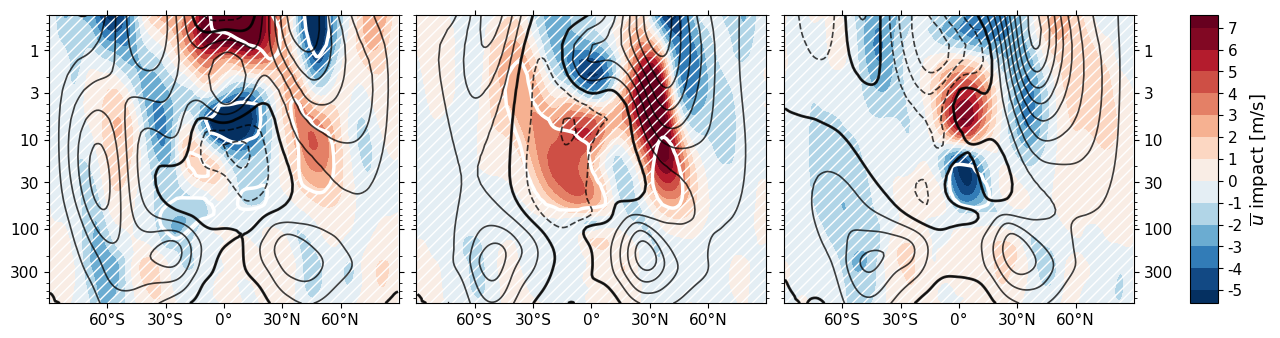

In [12]:
fig = plt.figure(figsize=(14,3.75))
#gs  = GridSpec(3, 2, figure=fig)
gs  = GridSpec(1, 3, figure=fig)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])

# ----- configure U, U impact levels
ulev  = np.arange(-30, 100, 10)
#ilev  = np.arange(-8, 8.1, 2)
ilev  = np.arange(-5, 7.1, 1)
inorm = putil.get_cmap_norm(ilev, 'twoslope')

# plot time-lat at levels
pmin, pmax = 0.3, 700
make_plot('latlev', ax0,  p=slice(pmin, pmax), tsel=slice(date(1991,10,1), date(1991,11,1)))
make_plot('latlev', ax1,  p=slice(pmin, pmax), tsel=slice(date(1992,2,1), date(1992,4,1)))
make_plot('latlev', ax2,  p=slice(pmin, pmax), tsel=slice(date(1992,11,1), date(1993,1,1)), legend=False, colorbar=True)

# format axes
putil.format_ticks(ax0)
putil.format_ticks(ax1, y=None)
putil.format_ticks(ax2, y='right')
#putil.format_ticks(ax3, x=None)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

plt.show()

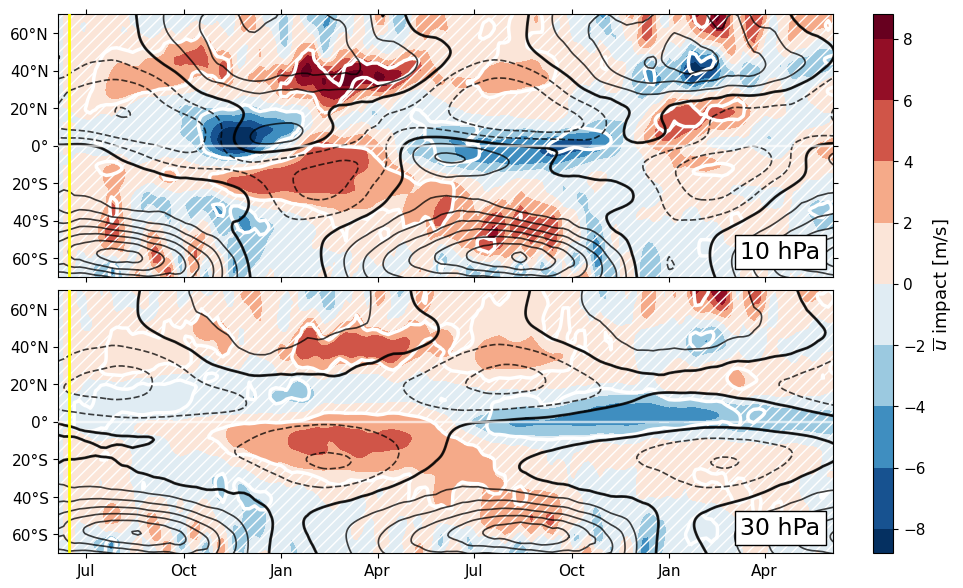

In [13]:
fig = plt.figure(figsize=(10,7))
gs  = GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

# ----- configure U, U impact levels
ulev  = np.arange(-30, 100, 10)
ilev  = np.arange(-8, 9, 2)
#ilev  = np.arange(-8, 8.1, 1)
inorm = putil.get_cmap_norm(ilev, 'twoslope')

# plot time-lat at levels
make_plot('timelat', ax1, p=10, colorbar=True)
make_plot('timelat', ax2, p=30)

# format axes
putil.format_ticks(ax1, x=None)
plt.subplots_adjust(wspace=0.075, hspace=0.05)
plt.show()

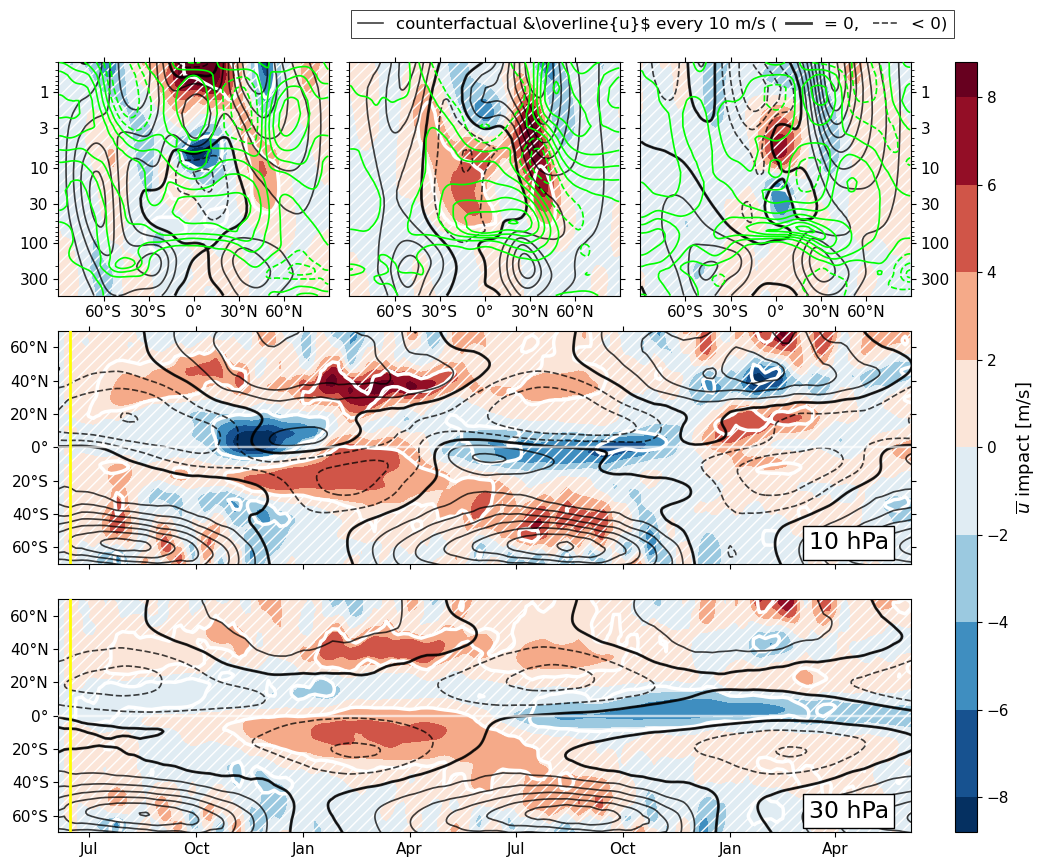

In [10]:
fig = plt.figure(figsize=(11,10))
#gs  = GridSpec(3, 2, figure=fig)
gs  = GridSpec(3, 3, figure=fig)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,:])
ax4 = fig.add_subplot(gs[2,:])

# ----- configure U, U impact levels
ulev  = np.arange(-30, 100, 10)
ilev  = np.arange(-8, 9, 2)
inorm = putil.get_cmap_norm(ilev, 'twoslope')

# plot time-lat at levels
make_plot('latlev', ax0,  p=slice(0.3, 500), tsel=slice(date(1991,10,1), date(1991,11,1)))
make_plot('latlev', ax1,  p=slice(0.3, 500), tsel=slice(date(1992,2,1), date(1992,4,1)))
make_plot('latlev', ax2,  p=slice(0.3, 500), tsel=slice(date(1992,11,1), date(1993,1,1)), legend=True)
make_plot('timelat', ax3, p=10, colorbar=True)
make_plot('timelat', ax4, p=30)

# format axes
putil.format_ticks(ax0)
putil.format_ticks(ax1, y=None)
putil.format_ticks(ax2, y='right')
putil.format_ticks(ax3, x=None)
plt.subplots_adjust(wspace=0.075, hspace=0.15)

plt.show()